In [2]:
from Notebooks.cifar10_import import *
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

## "Airplane" or "Banana": Classifying CIFAR-10

| Colin Yee, Reece Buyan, Ky-Vinh Mai

#### Summary

Our project is to create strategies to best classify images in the CIFAR-10 dataset using different classification models. Our classification models are:
1. Logisitic Regression
2. K-Nearest Neighbor
3. Feedforward Neural Network
4. Convolution Neural Network

From our experiments we concluded that:
- Logisitic Regression
- K-Nearest Neighbor
- Feedforward Neural Network
- Convolution Neural Network

#### Data Description

**CIFAR-10** consists of 60,000 colored images (32 x 32). Each image is labeled with one of 10 mutually exclusive classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck) 

https://paperswithcode.com/dataset/cifar-10

In [3]:
"""
By default, there are 50,000 images in the training set and 10,000 images in the testing set.
However, we will be combining these two sets to explore the entire dataset together.
"""
x_images, y_labels = importCifar10("combined")

Here are some facts about the CIFAR-10 dataset:

In [4]:
"""
Each "image" in the dataset is a (32 x 32 x 3) numpy matrix. Each slot in the (32 x 32) represents a pixel.
The 3-size array in each pixel represents an RGB color.
"""
x_images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [5]:
"""
The y_labels consists of 60,000 numbers from 0 to 9. Each number represents a different image label.
"""
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_uniq_labels = np.unique(y_labels)
for c,y in zip(class_names,y_uniq_labels):
    print(c,y)

airplane 0
automobile 1
bird 2
cat 3
deer 4
dog 5
frog 6
horse 7
ship 8
truck 9


<BarContainer object of 10 artists>

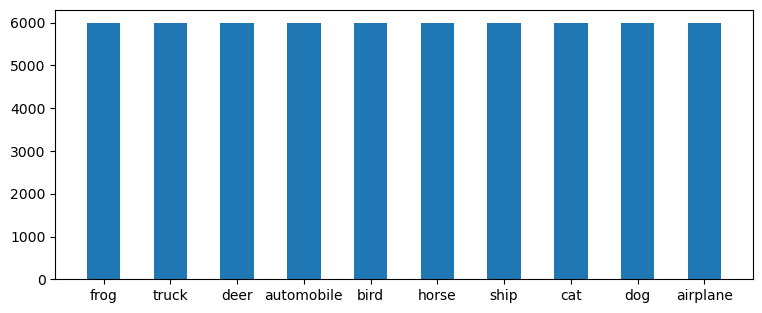

In [6]:
# Dataset contains same amount of images for each class
y_distribution = defaultdict(int)
for y in y_labels:
    y_distribution[class_names[y]]+=1

names = list(y_distribution.keys())
values = list(y_distribution.values())

fig = plt.figure(figsize=(9,3.5))
plt.bar(names,values,width=0.5)

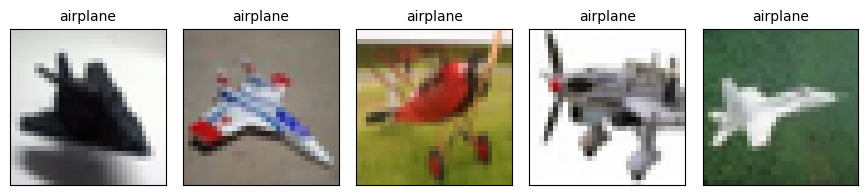

In [7]:
# Colors and backgrounds for each image may vary to some degree, but the object in each image follow a similar shape.
# That doesn't mean color and background has little role in the classification process...[INSERT MORE]
displayImages(5,x_images,y_labels,0)

#### Classifiers

In [8]:
def create_train_test_sets(x,y,scaled=True,gray=False):
    # Creating the training and testing sets (training is 60% of total)
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.6,stratify=y_labels,shuffle=True)

    # Create Validation Set (50% of test set)
    X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test,shuffle=True)

    if gray == True: X_train, X_val, X_test = grayScaleData(X_train, X_val, X_test)
    
    X_train, X_val, X_test = flattenImageSet(X_train,gray),flattenImageSet(X_val,gray),flattenImageSet(X_test,gray)

    if scaled == True:
        X_train, scalar = scaleImages(X_train)
        X_val = scaleImages(X_val,scalar)
        X_test = scaleImages(X_test,scalar)

    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [9]:
# Create datasets for models and validation
X_train, X_val, X_test, y_train, y_val, y_test = create_train_test_sets(x_images,y_labels)
X_cleaned, y_cleaned = np.vstack((X_train,X_val,X_test)),\
      np.hstack((y_train,y_val,y_test))
X_test_only, y_test_only = np.vstack((X_val,X_test)),np.hstack((y_val,y_test))

In [10]:
X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g = create_train_test_sets(x_images,y_labels,gray=True)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((24000, 3072), (18000, 3072), (18000, 3072))

*`K` Nearest Neighbor*

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

We trained the CIFAR-10 dataset on a K-Nearest Neighbor (kNN) Classifier. The kNN classifier works by calculating the distance between a new datapoint (e.g. image) and all the other data points in the training set. It finds the K nearest data points based on the distance and assigns the majority class (e.g. label) among these neighbors to the new data point.

The hyperparameters that we will be experimenting on is:
* `n_neighbors` {x > 0, x <= size of dataset}: The number of neighbors closest to a new data point that will determine its class.
* `weights` ['uniform', 'distance']: Weight/influence of neighbors in determining a point's class.


In addition, I will be experimenting with the model and dataset configuation to determine what's best for the given dataset. These ideas are:
1. Dimensionality Reduction (RBG vs Grayscaled images)
2. Classification Reduction (1 Multi-Classification Model vs 10 Binary Classifcation Models)
3. Bagging with Bootstrapping

For general experimentation with knn models, I split the 60,000 images into training, validation, and testing sets. 60% of the data would go to testing, 20% goes to validation, and 20% goes to testing.

However, in terms of selecting the best hyperparameter values for `n_neighbors` and `weights`, I used `GridSearchCV` where I put 66% of the images into training and 33% into testing. Both sets are stratified so that there is an equal representation of labels in each set.

[MAYBE EXPERIMENT WITH THE DATA PARTITIONS]

From the Grid Search, I found that a K-Nearest Neighbor model with `n_neighbors` = 5 and `weights` = `distance` performs the best. However, the testing accessories among the model configuations are lacking (30-35%)  

In [13]:
def gridSearch_knn(param_grid, cv, scoring, x, y, c = None):
    if c != None:
        y = [1 if c == class_names[i] else 0 for i in y]
    knn = KNeighborsClassifier(n_neighbors=5)
    grid = GridSearchCV(knn, param_grid, cv=cv, scoring=scoring, return_train_score=True)
    grid.fit(x,y)
    print(grid.best_score_)
    print(grid.best_params_)
    return grid

In [14]:
"""
kNN Helper Functions
"""
def plot_error_knn(x_train,x_test,y_train,y_test, weight = 'uniform'):
    figure, axes = plt.subplots(1, figsize=(5, 5))

    models = list()

    k = [2, 5, 7, 9, 10, 20, 50, 100]
    valid_error_y =  list()
    train_error_y = list()
    for i in k:
        neigh = KNeighborsClassifier(n_neighbors=i,weights=weight)
        neigh.fit(x_train,y_train)
        print(f"-- Created kNN for k = {i}")
        y_pred = neigh.predict(x_train)
        train_error_y.append(1 - accuracy_score(y_train,y_pred))
        y_pred = neigh.predict(x_test)
        valid_error_y.append(1 - accuracy_score(y_test,y_pred))
        print(f"-- Calculated Accuracy for k = {i}")
        models.append(neigh)

    axes.semilogx(k,train_error_y, color = "red", label = "Training Error")
    axes.semilogx(k,valid_error_y, color = "green", label = "Testing Error")
    axes.set_xlabel('k', fontsize=10)
    axes.set_ylabel('Error Rate', fontsize=10)
    axes.set_title("Error Rates vs k")
    axes.legend()
    return models

def cross_validate_knn():
    pass
def compute_accuracy_knn(
        model,
        x_train, x_test,
        y_train, y_test,
        conf_matrix = False,
        c = None
):
    if c != None:
        y_train = [1 if c == class_names[y] else 0 for y in y_train]
        y_test = [1 if c == class_names[y] else 0 for y in y_test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print()
    
    if conf_matrix == True:
        sklearn_cm = confusion_matrix(y_test, y_pred)
        sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm,display_labels=class_names)
        sklearn_disp.plot(xticks_rotation='vertical')
    
    return (model,accuracy_score(y_test,y_pred))

def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(f"Accuracy for kNN: {accuracy_score(y_test,y_pred)}")

    # Evaluate confusion matrix using your function compute_confusion_matrix
    sklearn_cm = confusion_matrix(y_test, y_pred)
    sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm,display_labels=class_names)
    sklearn_disp.plot(xticks_rotation='vertical')

In [15]:
k_range = list(range(1, 11, 2))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

In [16]:
X_train_val, y_train_val = np.vstack((X_train,X_val)),\
      np.hstack((y_train,y_val))

In [17]:
X_train_val_g, y_train_val_g = np.vstack((X_train_g,X_val_g)),\
      np.hstack((y_train_g,y_val_g))
X_test_only_g, y_test_only_g = np.vstack((X_val_g,X_test_g)),np.hstack((y_val_g,y_test_g))

In [ ]:
grid = gridSearch_knn(param_grid,3,'accuracy',X_train_val,y_train_val)

0.33421428571428574
{'n_neighbors': 7, 'weights': 'distance'}


In [ ]:
pd.DataFrame(grid.cv_results_)[['mean_train_score','mean_test_score', 'std_test_score', 'params']]

,mean_train_score,mean_test_score,std_test_score,params
0,1.000000,0.323000,0.001920,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,1.000000,0.323000,0.001920,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.562214,0.307762,0.002357,"{'n_neighbors': 3, 'weights': 'uniform'}"
3,1.000000,0.329857,0.003748,"{'n_neighbors': 3, 'weights': 'distance'}"
4,0.490488,0.318786,0.001843,"{'n_neighbors': 5, 'weights': 'uniform'}"
5,1.000000,0.334095,0.001483,"{'n_neighbors': 5, 'weights': 'distance'}"
6,0.449536,0.318500,0.001037,"{'n_neighbors': 7, 'weights': 'uniform'}"
7,1.000000,0.334214,0.002216,"{'n_neighbors': 7, 'weights': 'distance'}"
8,0.424226,0.319381,0.001517,"{'n_neighbors': 9, 'weights': 'uniform'}"
9,1.000000,0.333238,0.001999,"{'n_neighbors': 9, 'weights': 'distance'}"


In [ ]:
# It seems that k = 5 with weighted neigbors does the best
# However, the accuracy still needs to be improved upon.
print(grid.best_score_)
print(grid.best_params_)
model1 = grid.best_estimator_
print("Test Accuracy:",accuracy_score(y_test,model1.predict(X_test)))

0.33421428571428574
{'n_neighbors': 7, 'weights': 'distance'}
Test Accuracy: 0.3522777777777778


-- Created kNN for k = 2
-- Calculated Accuracy for k = 2
-- Created kNN for k = 5
-- Calculated Accuracy for k = 5
-- Created kNN for k = 7
-- Calculated Accuracy for k = 7
-- Created kNN for k = 9
-- Calculated Accuracy for k = 9
-- Created kNN for k = 10
-- Calculated Accuracy for k = 10
-- Created kNN for k = 20
-- Calculated Accuracy for k = 20
-- Created kNN for k = 50
-- Calculated Accuracy for k = 50
-- Created kNN for k = 100
-- Calculated Accuracy for k = 100


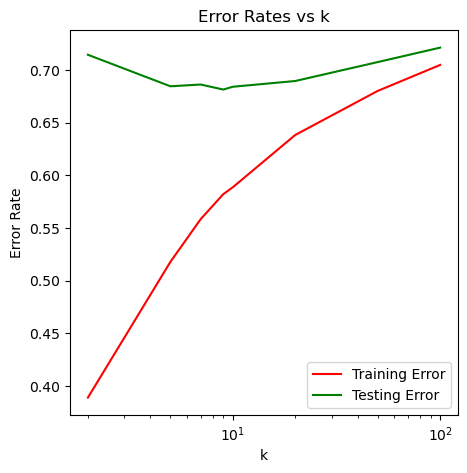

In [ ]:
knn_models_reg = plot_error_knn(X_train,X_val,y_train,y_val)

In [ ]:
k = [2, 5, 7, 9, 10, 20, 50, 100]
for i in range(8):
    print(f"{k[i]} neighbors: {accuracy_score(y_test,knn_models_reg[i].predict(X_test))}")

2 neighbors: 0.29
5 neighbors: 0.32033333333333336
7 neighbors: 0.3228888888888889
9 neighbors: 0.3225
10 neighbors: 0.3237777777777778
20 neighbors: 0.3151111111111111
50 neighbors: 0.3006666666666667
100 neighbors: 0.28605555555555556


-- Created kNN for k = 2
-- Calculated Accuracy for k = 2
-- Created kNN for k = 5
-- Calculated Accuracy for k = 5
-- Created kNN for k = 7
-- Calculated Accuracy for k = 7
-- Created kNN for k = 9
-- Calculated Accuracy for k = 9
-- Created kNN for k = 10
-- Calculated Accuracy for k = 10
-- Created kNN for k = 20
-- Calculated Accuracy for k = 20
-- Created kNN for k = 50
-- Calculated Accuracy for k = 50
-- Created kNN for k = 100
-- Calculated Accuracy for k = 100


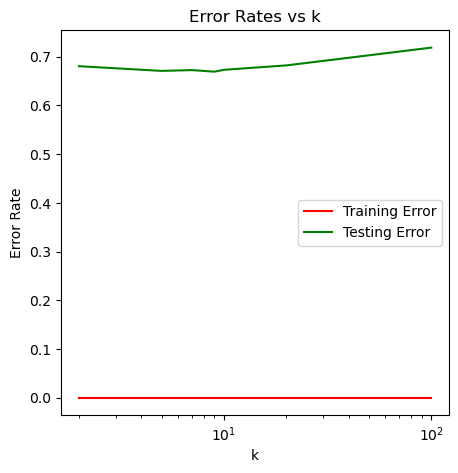

In [ ]:
knn_models_weigh = plot_error_knn(X_train,X_val,y_train,y_val,weight='distance')

In [ ]:
k = [2, 5, 7, 9, 10, 20, 50, 100]
for i in range(8):
    print(f"{k[i]} neighbors: {accuracy_score(y_test,knn_models_weigh[i].predict(X_test))}")

2 neighbors: 0.3233333333333333
5 neighbors: 0.33661111111111114
7 neighbors: 0.336
9 neighbors: 0.3362222222222222
10 neighbors: 0.3352777777777778
20 neighbors: 0.32522222222222225
50 neighbors: 0.30394444444444446
100 neighbors: 0.28794444444444445


-- Created kNN for k = 2
-- Calculated Accuracy for k = 2
-- Created kNN for k = 5
-- Calculated Accuracy for k = 5
-- Created kNN for k = 7
-- Calculated Accuracy for k = 7
-- Created kNN for k = 9
-- Calculated Accuracy for k = 9
-- Created kNN for k = 10
-- Calculated Accuracy for k = 10
-- Created kNN for k = 20
-- Calculated Accuracy for k = 20
-- Created kNN for k = 50
-- Calculated Accuracy for k = 50
-- Created kNN for k = 100
-- Calculated Accuracy for k = 100


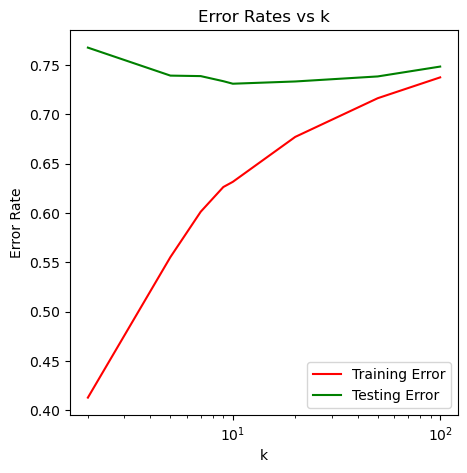

In [ ]:
knn_models_g = plot_error_knn(X_train_g,X_val_g,y_train_g,y_val_g)

In [ ]:
k = [2, 5, 7, 9, 10, 20, 50, 100]
for i in range(8):
    print(f"{k[i]} neighbors: {accuracy_score(y_test_g,knn_models_g[i].predict(X_test_g))}")

2 neighbors: 0.24205555555555555
5 neighbors: 0.26661111111111113
7 neighbors: 0.27055555555555555
9 neighbors: 0.27066666666666667
10 neighbors: 0.2712222222222222
20 neighbors: 0.2693888888888889
50 neighbors: 0.26005555555555554
100 neighbors: 0.24661111111111111


-- Created kNN for k = 2
-- Calculated Accuracy for k = 2
-- Created kNN for k = 5
-- Calculated Accuracy for k = 5
-- Created kNN for k = 7
-- Calculated Accuracy for k = 7
-- Created kNN for k = 9
-- Calculated Accuracy for k = 9
-- Created kNN for k = 10
-- Calculated Accuracy for k = 10
-- Created kNN for k = 20
-- Calculated Accuracy for k = 20
-- Created kNN for k = 50
-- Calculated Accuracy for k = 50
-- Created kNN for k = 100
-- Calculated Accuracy for k = 100


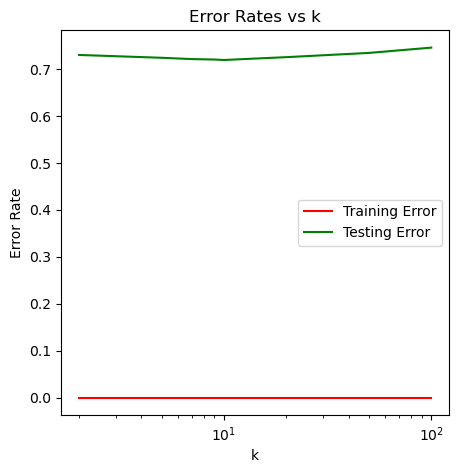

In [ ]:
knn_models_g_weigh = plot_error_knn(X_train_g,X_val_g,y_train_g,y_val_g,weight='distance')

In [ ]:
k = [2, 5, 7, 9, 10, 20, 50, 100]
for i in range(8):
    print(f"{k[i]} neighbors: {accuracy_score(y_test_g,knn_models_g_weigh[i].predict(X_test_g))}")

2 neighbors: 0.2776666666666667
5 neighbors: 0.2838333333333333
7 neighbors: 0.2871111111111111
9 neighbors: 0.2838333333333333
10 neighbors: 0.2833888888888889
20 neighbors: 0.278
50 neighbors: 0.26355555555555554
100 neighbors: 0.24938888888888888


I thought changing the images to grayscale might help the kNN model perform better since models that rely on distance usually struggle with higher dimensional data. There was definitely a decrease in the amount of time it takes to perform cross validation (13 min to 42 min). However, there was a significant decrease in in accuracy when training and testing the k-NN model on grayscale or RGB images. Color seems to play some role in determine what label an image is.

In [ ]:
grid_g = gridSearch_knn(param_grid,3,'accuracy',X_train_val_g,y_train_val_g)

0.2852619047619047
{'n_neighbors': 9, 'weights': 'distance'}


In [ ]:
pd.DataFrame(grid_g.cv_results_)[['mean_train_score','mean_test_score', 'std_test_score', 'params']]

,mean_train_score,mean_test_score,std_test_score,params
0,1.000000,0.275833,0.000681,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,1.000000,0.275833,0.000681,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.512060,0.257857,0.000823,"{'n_neighbors': 3, 'weights': 'uniform'}"
3,1.000000,0.279643,0.000498,"{'n_neighbors': 3, 'weights': 'distance'}"
4,0.444607,0.268405,0.004520,"{'n_neighbors': 5, 'weights': 'uniform'}"
5,1.000000,0.284214,0.003363,"{'n_neighbors': 5, 'weights': 'distance'}"
6,0.401405,0.268357,0.003211,"{'n_neighbors': 7, 'weights': 'uniform'}"
7,1.000000,0.284214,0.002342,"{'n_neighbors': 7, 'weights': 'distance'}"
8,0.377500,0.272071,0.000917,"{'n_neighbors': 9, 'weights': 'uniform'}"
9,1.000000,0.285262,0.001904,"{'n_neighbors': 9, 'weights': 'distance'}"


In [ ]:
print(grid_g.best_score_)
print(grid_g.best_params_)
model_g = grid_g.best_estimator_
print("Test Accuracy:",accuracy_score(y_test_g,model_g.predict(X_test_g)))

0.2852619047619047
{'n_neighbors': 9, 'weights': 'distance'}
Test Accuracy: 0.2995


Given that our previous models are trying to classify images into 10 different labels, it can be very difficult for the model to accurately predict. So instead of creating 1 single model, I created 10 different k-NN models, one for each label. They would use the same training images but the training labels will be modified to be binary where `1` indicates that an image belongs to their respective label.

Individually, each model does well in classifying images for their respective class. [INCLUDE EXPLANATION]. However, when combined together, it has the same dismal results since around half of the images are classified as 'nothing' where all 10 models mark them down as `0`. This was definitely a possibility of happening since these models are independent from one another (since they are all using slightly different training data.)

In [ ]:
grid_c_list = list()
for c in class_names:
    y_train_val_c = [1 if c == class_names[i] else 0 for i in y_train_val]
    grid = gridSearch_knn(param_grid,3,'accuracy',X_train_val,y_train_val_c,c=c)
    grid_c_list.append(grid)
    

0.9132142857142856
{'n_neighbors': 9, 'weights': 'distance'}


KeyboardInterrupt: 

In [ ]:
for i in range(10):
    y_test_c = [1 if i == y else 0 for y in y_test]
    print(f"=={class_names[i]} ({grid_c_list[i].best_params_}): {accuracy_score(y_test_c,grid_c_list[i].best_estimator_)}")

In [ ]:
y_train_c = [1 if 'airplane' == class_names[y] else 0 for y in y_train]
model = KNeighborsClassifier(n_neighbors=7,weights='distance')
model.fit(X_train,y_train_c)

KNeighborsClassifier(weights='distance')

In [ ]:
y_pred = model.predict(X_val)
print(y_pred)
y_val_c = [1 if 'airplane' == class_names[y] else 0 for y in y_val]

[1 0 0 ... 0 0 0]


AttributeError: 'list' object has no attribute 'T'

In [ ]:
print(type(y_pred))

<class 'numpy.ndarray'>


In [ ]:
print(accuracy_score(y_val_c,np.array(y_pred)))

16324


In [ ]:
print(sum(1 if y_c == 1 and y_c == y_p else 0 for y_c,y_p in zip(y_val_c,y_pred)))

694


In [ ]:
y_dict = dict()
y_dict["Predicted"] = y_pred
y_dict["Validated"] = y_val_c
y_dict["True"] = y_val
pd.DataFrame(y_dict).to_csv("airplane_test.csv")

In [ ]:
# These models are worthless...
knn_models = list()
for c in class_names:
    y_train_c = [1 if c == class_names[y] else 0 for y in y_train]
    model = KNeighborsClassifier(n_neighbors=5,weights='distance')
    model.fit(X_train,y_train_c)
    knn_models.append(model)

predictions = dict()
for i in range(10):
    predictions[f"{class_names[i]}"] = knn_models[i].predict(X_val).tolist()
    print(f"Predicted values for {class_names[i]}")

predictions["True Values"] = y_val.tolist()
pd.DataFrame(predictions).to_csv("testc.csv")

Predicted values for airplane
Predicted values for automobile
Predicted values for bird
Predicted values for cat
Predicted values for deer
Predicted values for dog
Predicted values for frog
Predicted values for horse
Predicted values for ship
Predicted values for truck


[LOOK AT TRAINING ERROR]

I believe that these models might be overfitting the data since it might be looking too close into the different RBG image values since it can't be generalized into ranges. So I will try to implement Bagging with Bootstrapping to see if I 

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report

In [4]:
knn_bag = BaggingClassifier(
    estimator=KNeighborsClassifier(n_neighbors=7,weights='distance'),
    n_estimators=17,
    max_samples=0.7,
    max_features=0.9
)
# With max_samples and max_features being around 0.6 - 0.8, still 33%
knn_bag.fit(X_train_val,y_train_val)
print("Finished creating bag")
y_pred = knn_bag.predict(X_test)

NameError: name 'KNeighborsClassifier' is not defined

              precision    recall  f1-score   support

    airplane       0.48      0.50      0.49      1800
  automobile       0.82      0.15      0.25      1800
        bird       0.25      0.39      0.30      1800
         cat       0.33      0.17      0.23      1800
        deer       0.21      0.59      0.32      1800
         dog       0.43      0.23      0.30      1800
        frog       0.33      0.29      0.31      1800
       horse       0.68      0.19      0.29      1800
        ship       0.35      0.71      0.47      1800
       truck       0.70      0.15      0.25      1800

    accuracy                           0.34     18000
   macro avg       0.46      0.34      0.32     18000
weighted avg       0.46      0.34      0.32     18000



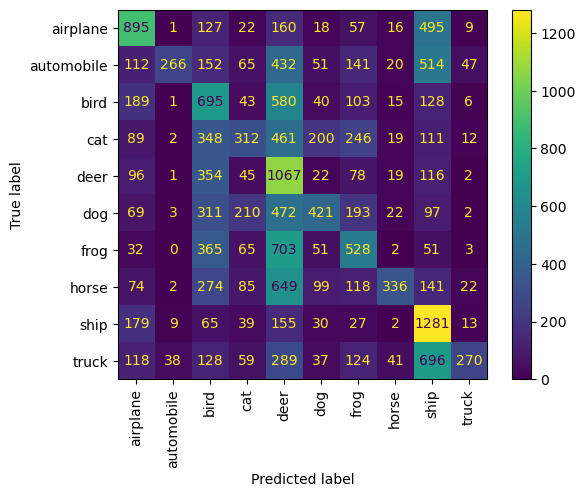

In [31]:
print(classification_report(y_test,y_pred,target_names=class_names))

sklearn_cm = confusion_matrix(y_test, y_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm,display_labels=class_names)
sklearn_disp.plot(xticks_rotation='vertical')

In [28]:
param_grid = {
    'max_samples' : [0.5,0.7,0.9,1],
    'max_features' : [0.5,0.7,0.9],
    'n_estimators' : list(range(3,18,2)),
    'n_neighbors' : list(range(3,12,2)),
    'weights' : ['uniform', 'distance']
}
import csv
with open('numbers.csv', 'w',newline="") as fileObj:
    writerObj = csv.writer(fileObj)
    writerObj.writerow(['samples', 'features', 'estimator', 'neighbors', 'weight','accuracy'])
    best_bag_acc = 0
    best_bag_model = None
    best_bag_params = list()
    for ms in param_grid['max_samples']:
        for mf in param_grid['max_features']:
            for e in param_grid['n_estimators']:
                for n in param_grid["n_neighbors"]:
                    for w in param_grid["weights"]:
                        clf = BaggingClassifier(
                            estimator=KNeighborsClassifier(n_neighbors=n,weights=w),
                            n_estimators=e,
                            max_samples=ms,
                            max_features=mf
                        )
                        clf.fit(X_train,y_train)
                        y_pred = clf.predict(X_val)
                        temp_acc = accuracy_score(y_val,y_pred)
                        print(f"({ms},{mf},{e},{n},{w}): {temp_acc}")
                        writerObj.writerow([ms,mf,e,n,w,temp_acc])
                        # best_bag_params.append((ms,mf,e,n,w,temp_acc))
                        if best_bag_acc < temp_acc:
                            best_bag_acc = temp_acc
                            best_bag_model = clf

"""
knn_bag = BaggingClassifier(
    estimator=KNeighborsClassifier(n_neighbors=5,weights='distance'),
    n_estimators=15,
    max_samples=0.5,
    max_features=0.5
)
# With max_samples and max_features being around 0.6 - 0.8, still 33%
knn_bag.fit(X_train_val,y_train_val)
print("Finished creating bag")
y_pred = knn_bag.predict(X_test)

print(classification_report(y_test,y_pred,target_names=class_names))

sklearn_cm = confusion_matrix(y_test, y_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm,display_labels=class_names)
sklearn_disp.plot(xticks_rotation='vertical')
"""
# y_pred = clf.predict(X_test)

# print(classification_report(y_test,y_pred,target_names=class_names))

(0.5,0.5,3,3,uniform): 0.3043888888888889
(0.5,0.5,3,3,distance): 0.30744444444444446
(0.5,0.5,3,5,uniform): 0.3036111111111111
(0.5,0.5,3,5,distance): 0.30905555555555553


KeyboardInterrupt: 